<a href="https://colab.research.google.com/github/JanLeyva/approach_TFM/blob/master/HM_ensamble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hateful Memes Ensamble

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read result files

In [69]:
# import .csv files from models results
import os
import pandas as pd
import numpy as np



drive = "/content/drive/MyDrive"
# All predictions are in `test_unseen` set
visualBERT_ = os.path.join(drive, "saveVisualBERT/save/hateful_memes_visual_bert_8294730/reports/hateful_memes_run_test_2022-03-10T15:54:05.csv")
visualBERTCoco_ = os.path.join(drive, "VisBERTCOCO/hateful_memes_visual_bert_10792640/reports/hateful_memes_run_test_2022-03-13T15:02:46.csv")
vilBERT_ = os.path.join(drive, "ViLbert/hateful_memes_vilbert_48408345/reports/hateful_memes_run_test_2022-03-11T17:00:38.csv")
ernie_vil_ = os.path.join(drive, "ernie-vil-results/ES365072_test_unseen_SA.csv")


## Local import

In [1]:
# local import
# import .csv files from models results
import os
import pandas as pd
import numpy as np

# visualBERT_ = ("hateful_memes_run_test_2022-03-10T15_54_05.csv") # not working well
visualBERTCoco_ = ("hateful_memes_run_test_2022-03-11T17_00_38.csv") 
vilBERT_ = ("hateful_memes_run_test_2022-03-13T14_53_38.csv")
ernie_vil_ = ("ES365072_test_unseen_SA.csv")

In [38]:
# visualBERT= pd.read_csv(visualBERT_) # not working well
visualBERTCoco= pd.read_csv(visualBERTCoco_) 
vilBERT= pd.read_csv(vilBERT_)
ernie_vil = pd.read_csv(ernie_vil_)
test_unseen = pd.read_json("test_unseen.jsonl", lines = True)

FileNotFoundError: [Errno 2] No such file or directory: 'hateful_memes_run_test_2022-03-11T17_00_38.csv'

In [12]:
# print("dim of visualBERT", visualBERT.shape)
print("dim of visualBERTCoco", visualBERTCoco.shape)
print("dim of vilBERT", vilBERT.shape)
print("dim of ernie_vil", ernie_vil.shape)
print("dim of test_unseen", test_unseen.shape)

dim of visualBERTCoco (2000, 3)
dim of vilBERT (2000, 3)
dim of ernie_vil (2000, 3)
dim of test_unseen (2000, 4)


In [4]:
# @title help function [ConfMatrix]
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics


def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values'); 

# Metrics

## VisualBERT

Accuracy: 0.688


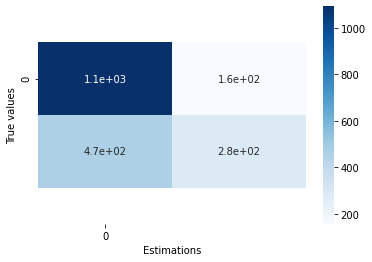

In [5]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], visualBERT['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], visualBERT['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [6]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], visualBERT['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.7257109333333334

## VisualBERT COCO

Accuracy: 0.686


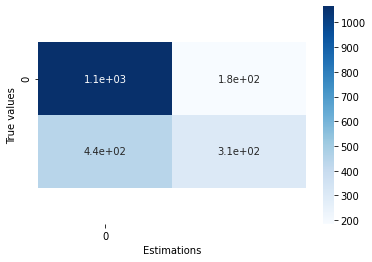

In [7]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], visualBERTCoco['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], visualBERTCoco['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [8]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], visualBERTCoco['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.7228373333333333

## ViLBERT

Accuracy: 0.4185


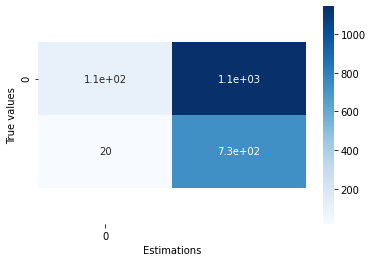

In [11]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], vilBERT['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], vilBERT['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [10]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], vilBERT['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.5294362666666668

## ERNIE-Vil

Accuracy: 0.625


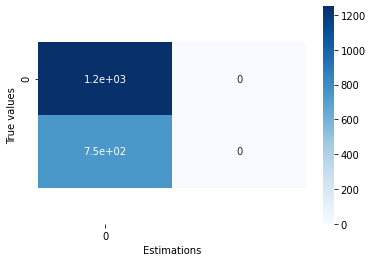

In [15]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], ernie_vil['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], ernie_vil['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], ernie_vil['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.8073365333333334

# 1st approach: Major voting
## 1.1. Hard Voting

Predict the class with the largest sum of votes from models


In [ ]:
def votingClassifier(resultsList, mode = "hard"):
  """
  resultsList: list of results. (list that contains results of each model), must be stored the results
  in label Column.
  mode:
    - hard: predict the class with the largest sum of votes from models
    - soft: predict the class with the largest summed probability from models.
  """
  newList = []
  for i in resultsList:
    newList.append(i['label'])


In [13]:
import glob
import shutil



def merge(dfs):
    return sum([df.proba.values for df in dfs]) / len(dfs)


def get_mean_predict(out_path):

    csv_list = glob.glob(visualBERT_)
    csv_list += glob.glob(visualBERTCoco_)
    csv_list += glob.glob(vilBERT_)
    csv_list += glob.glob(ernie_vil_)

    print(f"Found {len(csv_list)} csv eval result!")

    ensem_list = []
    All = False
    for csv_file in csv_list:
        # print(csv_file)
        if not All:
            yn = input(f"Include {csv_file} to ensemble? (y/n/all)")
        else:
            yn = 'y'
        yn = yn.strip().lower()
        if yn == 'all':
            All = True
        
        if yn == 'y' or All:
            ensem_list.append(csv_file)
            # dir_name = os.path.basename(os.path.dirname(csv_file))
            # shutil.copy(
            #     csv_file,
            #     os.path.join(
            #         gather_dir,
            #         f"{dir_name}_{os.path.basename(csv_file)}"
            #     )
            # )
    assert len(ensem_list) >= 2, f'You must select at least two file to ensemble, only {len(ensem_list)} is picked'
    
    base = pd.read_csv(ensem_list[0])
    print(len(ensem_list))
    ensem_list = [pd.read_csv(c) for c in ensem_list]
    base.proba = merge(ensem_list)



    # rasicm_idx = rasicm_det(
    #     os.path.join(root_dir, 'data/hateful_memes/test_unseen.jsonl'),
    #     os.path.join(root_dir, 'data/hateful_memes/box_annos.race.json'),
    #     os.path.join(root_dir, 'data/hateful_memes/img_clean'),
    # )
    # for i in rasicm_idx:
    #     base.at[int(base.index[base['id']==i].values), 'proba'] = 1.0

    base.to_csv(out_path, index=False)

In [14]:
get_mean_predict("test_set_enselble2.csv")

Found 4 csv eval result!
Include hateful_memes_run_test_2022-03-10T15_54_05.csv to ensemble? (y/n/all)y
Include hateful_memes_run_test_2022-03-11T17_00_38.csv to ensemble? (y/n/all)y
Include hateful_memes_run_test_2022-03-13T14_53_38.csv to ensemble? (y/n/all)y
Include ES365072_test_unseen_SA.csv to ensemble? (y/n/all)y
4


In [15]:
result = pd.read_csv("test_set_enselble2.csv")
#result2 = pd.read_csv("test_set_enselble2.csv")

Accuracy: 0.688


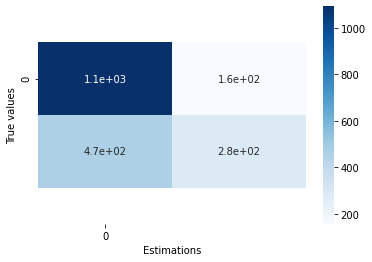

In [16]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], result['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], result['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [25]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], result['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.8084405333333334

## Second Results

Accuracy: 0.688


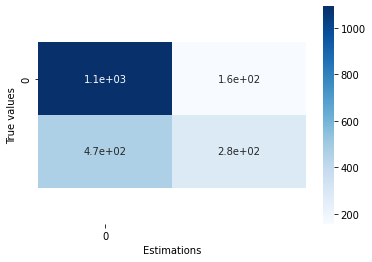

In [146]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], result2['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], result2['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [144]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], result2['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.8088373333333332

## 2.2. Soft Voting

Predict the class with the largest summed probability from models.

# 2nd Approach: logistic regression

In [53]:
X = pd.DataFrame()
X['ernie_vil'] = ernie_vil['label']
X['visualBERT'] = visualBERT['label']
X['visualBERTCoco'] = visualBERTCoco['label']
# X['vilBERT'] = vilBERT['label']

In [54]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X, test_unseen['label'])
pred_logistic = clf.predict(X)

In [55]:
clf.score(X, test_unseen['label'])

0.6845

Accuracy: 0.6845


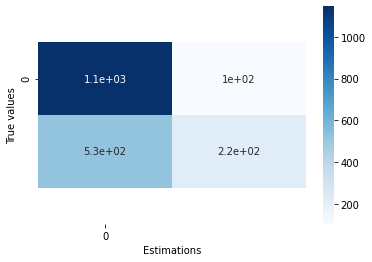

In [56]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], pred_logistic, 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], pred_logistic)
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [57]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], pred_logistic,  pos_label=1)
metrics.auc(fpr, tpr)

0.6070666666666668

# Racism rule

In [3]:
import pandas as pd
fairface_ = pd.read_json("fairface.json")

In [39]:
test_unseen = pd.read_json("test_unseen.jsonl", lines = True)

In [49]:
test_unseen.iloc[2]

id                        60792
img               img/60792.png
label                         1
text     the original derp-face
Name: 2, dtype: object

In [49]:
('Black' in fairface_.loc[4]['face_race4'])

True

In [64]:
fairface_['id']

0       96238
1        6213
2       13852
3       31769
4       15320
        ...  
5772    52617
5773    61347
5774    83056
5775    91675
5776    79234
Name: id, Length: 5777, dtype: int64

In [52]:
fairface_.items()

<generator object DataFrame.items at 0x7feb6c919890>

In [55]:
import os
import glob
import shutil

import spacy
nlp = spacy.load("en_core_web_lg")

OSError: [E050] Can't find model 'en_core_web_lg'. It doesn't seem to be a Python package or a valid path to a data directory.

In [69]:
match = ["123", "321", "456"]
fairface_anno = ["123", "678", "321"]

In [72]:
len(fairface_anno)

3

In [70]:
racism_results = []
for i in range(len(fairface_anno)):
    if fairface_anno[i] in match:
        racism_results.append(fairface_anno[i])

non racism detected!


In [71]:
racism_results

['123', '321']

In [127]:
nqwe = (fairface['id'].values)

In [128]:
nqwe

array([96238,  6213, 13852, ..., 83056, 91675, 79234])

In [136]:
32489 in nqwe

False

In [151]:
racism_results_ = []
for i in range(len(nqwe)):
    if str(nqwe[i]) in rasicm_sample_idx:
        racism_results_.append(nqwe[i])

In [144]:
str(nqwe[0])

'96238'

In [156]:
str(nqwe[3]) in rasicm_sample_idx

False

In [158]:
(nqwe)

array([96238,  6213, 13852, ..., 83056, 91675, 79234])

In [97]:
fairface = pd.read_json("fairface.json")

In [73]:
rasicm_sample_idx = ['08179', '30941', '32489', '60158', '08679', '04851', '08612', '69514', '34218', '32149', '68510', '34762', '28364', '96057', '70653', '31672', '54721', '78169', '08129', '06594', '32657', '36271', '90187', '06731', '95438', '31427', '02564', '38056', '58760', '98735', '50863', '15387', '39610', '56810', '12396', '84793', '72193', '89473', '79810', '70698', '29857', '35726', '37942', '04739', '85642', '70325', '42571', '52397', '40397', '89765', '63195', '87106', '53640', '65372', '31976', '48023', '12690', '70498', '68705', '84657', '79218', '64951', '46879', '52069', '48327', '98326', '27148', '27310', '27609', '56120', '09317', '64037', '73140', '08145', '47935', '58460', '41290', '32596', '06918', '12768', '82451', '23741', '46897', '98541', '47562', '09256', '83029', '74396', '41269', '70682', '36908', '89230', '13572', '92418', '13457', '73916', '48195', '05142', '91870', '71069', '57864', '32690', '19257', '18563', '07524', '35081', '39172', '79524', '12367', '85943', '96370', '07214', '14365', '60123', '67532', '54368', '10789', '34267', '24837', '83709', '49582', '49567', '83106', '71856', '68304', '50691', '62584', '10387', '43021']

In [74]:
fairface_anno = [31769, 15320, 21534, 79032, 28134, 70624, 87023, 5164, 86753, 56104, 10538, 69470, 26370, 14530, 94625, 14789, 35724, 96152, 70842, 67953, 15690, 76539, 94721, 28973, 78492, 86017, 79845, 25067, 14530, 29460, 25107, 14530, 13470, 62745, 82457, 14530, 45836, 30481, 96328, 18759, 10358, 19503, 4859, 89324, 68019, 6791, 37284, 41372, 83517, 65712, 43716, 8395, 58473, 38514, 80652, 93072, 98463, 16849, 43095, 90576, 23957, 75204, 28154, 41853, 96752, 78610, 46753, 31472, 81724, 92876, 19256, 21593, 21394, 70534, 81976, 49208, 31729, 71046, 70865, 91348, 46097, 29138, 7248, 36102, 38514, 84563, 76483, 75321, 25971, 37642, 67439, 28154, 15374, 97301, 14530, 43198, 70842, 92876, 90251, 72945, 14329, 84106, 50397, 96845, 16783, 40852, 41503, 70582, 50861, 85729, 60439, 41203, 87425, 51683, 86351, 20195, 34079, 5483, 56741, 46501, 9364, 70624, 43716, 86205, 37049, 49327, 28063, 46721, 75649, 61450, 28970, 4782, 21593, 87914, 28516, 89372, 50931, 70194, 29460, 80297, 18730, 36459, 6948, 68937, 49615, 75649, 12673, 97315, 39465, 3794, 69472, 86013, 90836, 41857, 39478, 13906, 81942, 37214, 28134, 41857, 93081, 21648, 58109, 56290, 94721, 92573, 54629, 2764, 31205, 80297, 16780, 75823, 47239, 65807, 57469, 28173, 86217, 37208, 31684, 71925, 83972, 90165, 17965, 5973, 34021, 86075, 74083, 86142, 15906, 21936, 36025, 28970, 79638, 15804, 32069, 70845, 64215, 48125, 38465, 74083, 7956, 26371, 95081, 51836, 3981, 71294, 3472, 89072, 31769, 58160, 21038, 80197, 59043, 8176, 28134, 92381, 70395, 80942, 86045, 81720, 65204, 51237, 23054, 38209, 49173, 90834, 68937, 89072, 46753, 86329, 32941, 81764, 4651, 2475, 31294, 93687, 43162, 56179, 21593, 34506, 59678, 20195, 94065, 86201, 67953, 74315, 70319, 36524, 25791, 8234, 86701, 46239, 87324, 53296, 78903, 94205, 10926, 17034, 85927, 68159, 32106, 57693, 36210, 70624, 49280, 90583, 58419, 71285, 28735, 43095, 75192, 23159, 28134, 46701, 43791, 46081, 89675, 41387, 79680, 27318, 28063, 79286, 27965, 90847, 46753, 31729, 68137, 42178, 64327, 48213, 76489, 48125, 36524, 2971, 60357, 21548, 4651, 81940, 75823, 45612, 97543, 10752, 36097, 75294, 54068, 12956, 19026, 76450, 5973, 9768, 75908, 40916, 54690, 53017, 28195, 30761, 64127, 93260, 19408, 92734, 78903, 36751, 76910, 71046, 13764, 8962, 97051, 14530, 32941, 54981, 83052, 43716, 70158, 67132, 34157, 81724, 47196, 92613, 26803, 83619, 12489, 19256, 83052, 82603, 79658, 26370, 28063, 93852, 39158, 79286, 47826, 59468, 25791, 71046, 42187, 50372, 28970, 14523, 51209, 71046, 36751, 80297, 9187, 28970, 81097, 21936, 94356, 19408, 74315, 67849, 23501, 23841, 78492, 74315, 63710, 46827, 67043, 85362, 72035, 92614, 27016, 14530, 75649, 38069, 28970, 87425, 37642, 68531, 57693, 49786, 38127, 69708, 14530, 45723, 63710, 60214, 18739, 46208, 27385, 49810, 73609, 35642, 28134, 58637, 9364, 15420, 36480, 70132, 56179, 3547, 71294, 18397, 48175, 39067, 18759, 28970, 54973, 26750, 1379, 62731, 83256, 28970, 36751, 28970, 31769, 36025, 39861, 28970, 89437, 70426, 32941, 63201, 59468, 25716, 58170, 24376, 73154, 72945, 50328, 35016, 95724, 16734, 90126, 48263, 72340, 65328, 47612, 79286, 27803, 20386, 65183, 14530, 24165, 43095, 90427, 94625, 85967, 31205, 43095, 5798, 38105, 27153, 13579, 10489, 27318, 81097, 29756, 5798, 81265, 46097, 8654, 21038, 42065, 2571, 78539, 5138, 85073, 59678, 28739, 79681, 51460, 86217, 64780, 83650, 37295, 27041, 19860, 18529, 18650, 57042, 71486, 52036, 36508, 36025, 86351, 5468, 59621, 28970, 38245, 38514, 67980, 40916, 58924, 75649, 21347, 28970, 38251, 16947, 20578, 15726, 64215, 56210, 31729, 70539, 70928, 23841, 91765, 28134, 79605, 63052, 94087, 20857, 26839, 79605, 49675, 50624, 25907, 17582, 26839, 90146, 63281, 28970, 63520, 43095, 87324, 81097, 32069, 28516, 65978, 32941, 28970, 82503, 75649, 84209, 50937, 47826, 62301, 12673, 25816, 85741, 19860, 31684, 14530, 24851, 49786, 46183, 94087, 9648, 5384, 4651, 21534, 42178, 29460, 5798, 53260, 42185, 49128, 80297, 57814, 79854, 37096, 53017, 9176, 94370, 39401, 52614, 78591, 62745, 43095, 14530, 57914, 94721, 28970, 57180, 27043, 59043, 41597, 75192, 72035, 7634, 73609, 91708, 28134, 79104, 56738, 13276, 89372, 9284, 92613, 84531, 34081, 65240, 41078, 19458, 1746, 41857, 73198, 87412, 19256, 59143, 6248, 8254, 90126, 7618, 28970, 58023, 70652, 38046, 62745, 82460, 54896, 28134, 72945, 14530, 98643, 25107, 34629, 16587, 64327, 35062, 46710, 47826, 34805, 26034, 29851, 79385, 16849, 28970, 54931, 78610, 50784, 97543, 83296, 78903, 6725, 17589, 29678, 30761, 78591, 83650, 75294, 23159, 27043, 26043, 78610, 28019, 40965, 67980, 67439, 36054, 43716, 46387, 62514, 87425, 32906, 34079, 57631, 96152, 76285, 59043, 28973, 47826, 24083, 19324, 94352, 12673, 19324, 43716, 13269, 19408, 28970, 42687, 96071, 56179, 58473, 70395, 75649, 96701, 71082, 75319, 64127, 6791, 92876, 17093, 90146, 80193, 27816, 87023, 79605, 21963, 29460, 43527, 12907, 24319, 71389, 19452, 39624, 21963, 59863, 49675, 17493, 92876, 57893, 8234, 50624, 28134, 28970, 87120, 92170, 82531, 43780, 81097, 49208, 24751, 51809, 48125, 93487, 74380, 92614, 18739, 43791, 16048, 34805, 41806, 32947, 83901, 12953, 45213, 85729, 21936, 91482, 13968, 64318, 54092, 58210, 13579, 75204, 23416, 5276, 14530, 70132, 28134, 96152, 32507, 54896, 56104, 23841, 90582, 76539, 94350, 2614, 74380, 34798, 6897, 61840, 15328, 59761, 21693, 75204, 60173, 12953, 19532, 74096, 60973, 45630, 72910, 13506, 12489, 31729, 71583, 61205, 1924, 51037, 12673, 61823, 13906, 17850, 21890, 50741, 3418, 2863, 16948, 83256, 67254, 14726, 43095, 49675, 79315, 62457, 3241, 3942, 6275, 70842, 4682, 89437, 31742, 37825, 26370, 74315, 68901, 71285, 6725, 3756, 14530, 1892, 8517, 95186, 89437, 37096, 46710, 59621, 5926, 41372, 75823, 74901, 45201, 20184, 37049, 61894, 17589, 5276, 13764, 59364, 15320, 49675, 98643, 48697, 47530, 83014, 56834, 79605, 63941, 79385, 32069, 35724, 67953, 59468, 30745, 84910, 81097, 57302, 75468, 5483, 60134, 50328, 78610, 27043, 71486, 28613, 32941, 36982, 19408, 86205, 47859, 51209, 67328, 80967, 59217, 49680, 68329, 50149, 35271, 35084, 75649, 61093, 81946, 7249, 53182, 87530, 48213, 3547, 46710, 70183, 56179, 15029, 45201, 27563, 70395, 28134, 18739, 68327, 21038, 56108, 68913, 89437, 15029, 45037, 81097, 15029, 68913, 58924, 47913, 9834, 28516, 43095, 74563, 23759, 28134, 92614, 54710, 29460, 20578, 59143, 92867, 59478, 95081, 5269, 70835, 54629, 90516, 28613, 73956, 41068, 89675, 30761, 51037, 45612, 59837, 45037, 92613, 80976, 97543, 45612, 14530, 12489, 56738, 26140, 28154, 58134, 49615, 23851, 16874, 19256, 28134, 52986, 86217, 5241, 67043, 51608, 8439, 36102, 40916, 19420, 40965, 2475, 30829, 6349, 62178, 35724, 97826, 1392, 17582, 72164, 75294, 56418, 63207, 58679, 70465, 39785, 39624, 80317, 7438, 75204, 82079, 93852, 56432, 89726, 79584, 67953, 34795, 90638, 29460, 7438, 76489, 18640, 93468, 62745, 3691, 98702, 43716, 20578, 17052, 37642, 49173, 89437, 23698, 94205, 27043, 45120, 12489, 75231, 23698, 83056, 70845, 72951, 48125, 97543, 23715, 13652, 27405, 48069, 14530, 8742, 86201, 58160, 98731, 8962, 94356, 52318, 42953, 10936, 23910, 24083, 2571, 91457, 45201, 87324, 25791, 71046, 91845, 89372, 76894, 60973, 63520, 2764, 74563, 90165, 75204, 29814, 24603, 21347, 12673, 69470, 15690, 84172, 80317, 3472, 61834, 45832, 54301, 27043, 15824, 98643, 28973, 30761, 41857, 81720, 92876, 40916, 70842, 68094, 14530, 24395, 21936, 68259, 28605, 78610, 16849, 58674, 70158, 81720, 42178, 17582, 84276, 27438, 80197, 67953, 89324, 50931, 80742, 42510, 43716, 2614, 32480, 28134, 86135, 5276, 79286, 57302, 46198, 96152, 23054, 43095, 37182, 72514, 16048, 16593, 63201, 32980, 14530, 6791, 60234, 34872, 32615, 76495, 42856, 7968, 28970, 46208, 62745, 41372, 50679, 12956, 67953, 76293, 74930, 16849, 7391, 91462, 84965, 31205, 20184, 68937, 21963, 31684, 36524, 54692, 23416, 81259, 4762, 26371, 20184, 63281, 52613, 59761, 79605, 41986, 83509, 36214, 23054, 63709, 69470, 20578, 73248, 23807, 2156, 30548, 32069, 5269, 94721, 14297, 76254, 89302, 32470, 25943, 80197, 45806, 45832, 19452, 75428, 70132, 25791, 32015, 89123, 28405, 75693, 62084, 87324, 89561, 84392, 58109, 90654, 89726, 19324, 41857, 94625, 28604, 59143, 3547, 39158, 52078, 91024, 27034, 58160, 54690, 56179, 8517, 68309, 42163, 64870, 45072, 51682, 75192, 13269, 96701, 7391, 14530, 61840, 93761, 57693, 10254, 70162, 64925, 16892, 41385, 28516, 91024, 37096, 35084, 21648, 28063, 62713, 51076, 58109, 82539, 42510, 29084, 45201, 69087, 21548, 20195, 43612, 72984, 97628, 46217, 8345, 14329, 26371, 8372, 51462, 36048, 53941, 26014, 78539, 78539, 74892, 42178, 28613, 35971, 14297, 94625, 92741, 81423, 73609, 91356, 56418, 90638, 63281, 36542, 94625, 69472, 15804, 51809, 13276, 91627, 75102, 92408, 41986, 73154, 29460, 2571, 74096, 78923, 53182, 37642, 8234, 15824, 51209, 91423, 50817, 25791, 46753, 8162, 75046, 54692, 85714, 2316, 49128, 83025, 25791, 64327, 49810, 49170, 28134, 25791, 51460, 40712, 75693, 17965, 4217, 2764, 1658, 35084, 7926, 50328, 49280, 85290, 8962, 2971, 4568, 80976, 1924, 48307, 52479, 10489, 18379, 21387, 43527, 72340, 94721, 91840, 28970, 31769, 31085, 75192, 54690, 50624, 42187, 24319, 87639, 87619, 42187, 41503, 2431, 69128, 70865, 67041, 14958, 30961, 86142, 1658, 20386, 26078, 10725, 28970, 28391, 53182, 93246, 78219, 62745, 8126, 79605, 90285, 70395, 61480, 48125, 45836, 69472, 43702, 12489, 32491, 37049, 5164, 37924, 78913, 41857, 23054, 18759, 45213, 89675, 58674, 76894, 30456, 76152, 69472, 30761, 75098, 38046, 36210, 56738, 21963, 90516, 28134, 3271, 7984, 48213, 15029, 28134, 3795, 21593, 45267, 90146, 5614, 61823, 69470, 49680, 9184, 14297, 50741, 46097, 31560, 68309, 53260, 16892, 78219, 43657, 79584, 56712, 87324, 73816, 42093, 42178, 26031, 48317, 60439, 58473, 47239, 30764, 53914, 62301, 67348, 1756, 46081, 75198, 29485, 58210, 94871, 71285, 18675, 8591, 80317, 2156, 32069, 28063, 7826, 75693, 56834, 20671, 36098, 38514, 70194, 81097, 3845, 43657, 89523, 71046, 89675, 69470, 42187, 49128, 70352, 25107, 32906, 85243, 15320, 91827, 69470, 78610, 87620, 1379, 93468, 69415, 34506, 53182, 36524, 85026, 27041, 65183, 53914, 75693, 73091, 32069, 41372, 21569, 28970, 63057, 32150, 71046, 76152, 82316, 62105, 78610, 58109, 67298, 1924, 89504, 24083, 86135, 17493, 92734, 21548, 62301, 91647, 18739, 14083, 87425, 8423, 21963, 3691, 9364, 5276, 39540, 91840, 70132, 97804, 87639, 35016, 13269, 73198, 41379, 32615, 96152, 67953, 28134, 23841, 42853, 82457, 59043, 5276, 58473, 92876, 32906, 70842, 43791, 1698, 59761, 54692, 58904, 94356, 32069, 39540, 56179, 35971, 61453, 18730, 82503, 2984, 57132, 3418, 93852, 50961, 7438, 28160, 43095, 75693, 34805, 43095, 30185, 63201, 13269, 94130, 64327, 16892, 57469, 91845, 23961, 63720, 69175, 94871, 15420, 7391, 16849, 89437, 3795, 14590, 5269, 35724, 75290, 18730, 42853, 63985, 42309, 8234, 50273, 60973, 80926, 25067, 75294, 31742, 47913, 58642, 98764, 75908, 56179, 87902, 90427, 42309, 90638, 68745, 87409, 94205, 41857, 59217, 28973, 43095, 9615, 71486, 89726, 43162, 43198, 10259, 41387, 91240, 79406, 19036, 53182, 30761, 1943, 89072, 78903, 39706, 68327, 58372, 64825, 90516, 16947, 47530, 46217, 70624, 85704, 12957, 51460, 61570, 79103, 91358, 49208, 75382, 70319, 81946, 42065, 64127, 80297, 28973, 29158, 61480, 36972, 20957, 62308, 73180, 92578, 90165, 86075, 75693, 57180, 49128, 56179, 32941, 28173, 51249, 9187, 29835, 3185, 61937, 24130, 79854, 17953, 34570, 13579, 58276, 94615, 29814, 28074, 41857, 96152, 36501, 76539, 15983, 32941, 28973, 8654, 58071, 78610, 13570, 83619, 49867, 70865, 51802, 3547, 43095, 62731, 71058, 64752, 58160, 37049, 5276, 79584, 80941, 13906, 35016, 9834, 59376, 51706, 45219, 38514, 91462, 26803, 19085, 18397, 49810, 84091, 5276, 35967, 10489, 31769, 1529, 92854, 8234, 46710, 73609, 60973, 14679, 9468, 30291, 81679, 29671, 28134, 62105, 14530, 31769, 75290, 83056]

In [78]:
fairface_anno = ['08179', '31769', '15320', '21534', '79032', '28134', '70624', '87023', '5164', '86753', '56104', '10538', '69470', '26370', '14530', '94625', '14789', '35724', '96152', '70842', '67953', '15690', '76539', '94721', '28973', '78492', '86017', '79845', '25067', '14530', '29460', '25107', '14530', '13470', '62745', '82457', '14530', '45836', '30481', '96328', '18759', '10358', '19503', '4859', '89324', '68019', '6791', '37284', '41372', '83517', '65712', '43716', '8395', '58473', '38514', '80652', '93072', '98463', '16849', '43095', '90576', '23957', '75204', '28154', '41853', '96752', '78610', '46753', '31472', '81724', '92876', '19256', '21593', '21394', '70534', '81976', '49208', '31729', '71046', '70865', '91348', '46097', '29138', '7248', '36102', '38514', '84563', '76483', '75321', '25971', '37642', '67439', '28154', '15374', '97301', '14530', '43198', '70842', '92876', '90251', '72945', '14329', '84106', '50397', '96845', '16783', '40852', '41503', '70582', '50861', '85729', '60439', '41203', '87425', '51683', '86351', '20195', '34079', '5483', '56741', '46501', '9364', '70624', '43716', '86205', '37049', '49327', '28063', '46721', '75649', '61450', '28970', '4782', '21593', '87914', '28516', '89372', '50931', '70194', '29460', '80297', '18730', '36459', '6948', '68937', '49615', '75649', '12673', '97315', '39465', '3794', '69472', '86013', '90836', '41857', '39478', '13906', '81942', '37214', '28134', '41857', '93081', '21648', '58109', '56290', '94721', '92573', '54629', '2764', '31205', '80297', '16780', '75823', '47239', '65807', '57469', '28173', '86217', '37208', '31684', '71925', '83972', '90165', '17965', '5973', '34021', '86075', '74083', '86142', '15906', '21936', '36025', '28970', '79638', '15804', '32069', '70845', '64215', '48125', '38465', '74083', '7956', '26371', '95081', '51836', '3981', '71294', '3472', '89072', '31769', '58160', '21038', '80197', '59043', '8176', '28134', '92381', '70395', '80942', '86045', '81720', '65204', '51237', '23054', '38209', '49173', '90834', '68937', '89072', '46753', '86329', '32941', '81764', '4651', '2475', '31294', '93687', '43162', '56179', '21593', '34506', '59678', '20195', '94065', '86201', '67953', '74315', '70319', '36524', '25791', '8234', '86701', '46239', '87324', '53296', '78903', '94205', '10926', '17034', '85927', '68159', '32106', '57693', '36210', '70624', '49280', '90583', '58419', '71285', '28735', '43095', '75192', '23159', '28134', '46701', '43791', '46081', '89675', '41387', '79680', '27318', '28063', '79286', '27965', '90847', '46753', '31729', '68137', '42178', '64327', '48213', '76489', '48125', '36524', '2971', '60357', '21548', '4651', '81940', '75823', '45612', '97543', '10752', '36097', '75294', '54068', '12956', '19026', '76450', '5973', '9768', '75908', '40916', '54690', '53017', '28195', '30761', '64127', '93260', '19408', '92734', '78903', '36751', '76910', '71046', '13764', '8962', '97051', '14530', '32941', '54981', '83052', '43716', '70158', '67132', '34157', '81724', '47196', '92613', '26803', '83619', '12489', '19256', '83052', '82603', '79658', '26370', '28063', '93852', '39158', '79286', '47826', '59468', '25791', '71046', '42187', '50372', '28970', '14523', '51209', '71046', '36751', '80297', '9187', '28970', '81097', '21936', '94356', '19408', '74315', '67849', '23501', '23841', '78492', '74315', '63710', '46827', '67043', '85362', '72035', '92614', '27016', '14530', '75649', '38069', '28970', '87425', '37642', '68531', '57693', '49786', '38127', '69708', '14530', '45723', '63710', '60214', '18739', '46208', '27385', '49810', '73609', '35642', '28134', '58637', '9364', '15420', '36480', '70132', '56179', '3547', '71294', '18397', '48175', '39067', '18759', '28970', '54973', '26750', '1379', '62731', '83256', '28970', '36751', '28970', '31769', '36025', '39861', '28970', '89437', '70426', '32941', '63201', '59468', '25716', '58170', '24376', '73154', '72945', '50328', '35016', '95724', '16734', '90126', '48263', '72340', '65328', '47612', '79286', '27803', '20386', '65183', '14530', '24165', '43095', '90427', '94625', '85967', '31205', '43095', '5798', '38105', '27153', '13579', '10489', '27318', '81097', '29756', '5798', '81265', '46097', '8654', '21038', '42065', '2571', '78539', '5138', '85073', '59678', '28739', '79681', '51460', '86217', '64780', '83650', '37295', '27041', '19860', '18529', '18650', '57042', '71486', '52036', '36508', '36025', '86351', '5468', '59621', '28970', '38245', '38514', '67980', '40916', '58924', '75649', '21347', '28970', '38251', '16947', '20578', '15726', '64215', '56210', '31729', '70539', '70928', '23841', '91765', '28134', '79605', '63052', '94087', '20857', '26839', '79605', '49675', '50624', '25907', '17582', '26839', '90146', '63281', '28970', '63520', '43095', '87324', '81097', '32069', '28516', '65978', '32941', '28970', '82503', '75649', '84209', '50937', '47826', '62301', '12673', '25816', '85741', '19860', '31684', '14530', '24851', '49786', '46183', '94087', '9648', '5384', '4651', '21534', '42178', '29460', '5798', '53260', '42185', '49128', '80297', '57814', '79854', '37096', '53017', '9176', '94370', '39401', '52614', '78591', '62745', '43095', '14530', '57914', '94721', '28970', '57180', '27043', '59043', '41597', '75192', '72035', '7634', '73609', '91708', '28134', '79104', '56738', '13276', '89372', '9284', '92613', '84531', '34081', '65240', '41078', '19458', '1746', '41857', '73198', '87412', '19256', '59143', '6248', '8254', '90126', '7618', '28970', '58023', '70652', '38046', '62745', '82460', '54896', '28134', '72945', '14530', '98643', '25107', '34629', '16587', '64327', '35062', '46710', '47826', '34805', '26034', '29851', '79385', '16849', '28970', '54931', '78610', '50784', '97543', '83296', '78903', '6725', '17589', '29678', '30761', '78591', '83650', '75294', '23159', '27043', '26043', '78610', '28019', '40965', '67980', '67439', '36054', '43716', '46387', '62514', '87425', '32906', '34079', '57631', '96152', '76285', '59043', '28973', '47826', '24083', '19324', '94352', '12673', '19324', '43716', '13269', '19408', '28970', '42687', '96071', '56179', '58473', '70395', '75649', '96701', '71082', '75319', '64127', '6791', '92876', '17093', '90146', '80193', '27816', '87023', '79605', '21963', '29460', '43527', '12907', '24319', '71389', '19452', '39624', '21963', '59863', '49675', '17493', '92876', '57893', '8234', '50624', '28134', '28970', '87120', '92170', '82531', '43780', '81097', '49208', '24751', '51809', '48125', '93487', '74380', '92614', '18739', '43791', '16048', '34805', '41806', '32947', '83901', '12953', '45213', '85729', '21936', '91482', '13968', '64318', '54092', '58210', '13579', '75204', '23416', '5276', '14530', '70132', '28134', '96152', '32507', '54896', '56104', '23841', '90582', '76539', '94350', '2614', '74380', '34798', '6897', '61840', '15328', '59761', '21693', '75204', '60173', '12953', '19532', '74096', '60973', '45630', '72910', '13506', '12489', '31729', '71583', '61205', '1924', '51037', '12673', '61823', '13906', '17850', '21890', '50741', '3418', '2863', '16948', '83256', '67254', '14726', '43095', '49675', '79315', '62457', '3241', '3942', '6275', '70842', '4682', '89437', '31742', '37825', '26370', '74315', '68901', '71285', '6725', '3756', '14530', '1892', '8517', '95186', '89437', '37096', '46710', '59621', '5926', '41372', '75823', '74901', '45201', '20184', '37049', '61894', '17589', '5276', '13764', '59364', '15320', '49675', '98643', '48697', '47530', '83014', '56834', '79605', '63941', '79385', '32069', '35724', '67953', '59468', '30745', '84910', '81097', '57302', '75468', '5483', '60134', '50328', '78610', '27043', '71486', '28613', '32941', '36982', '19408', '86205', '47859', '51209', '67328', '80967', '59217', '49680', '68329', '50149', '35271', '35084', '75649', '61093', '81946', '7249', '53182', '87530', '48213', '3547', '46710', '70183', '56179', '15029', '45201', '27563', '70395', '28134', '18739', '68327', '21038', '56108', '68913', '89437', '15029', '45037', '81097', '15029', '68913', '58924', '47913', '9834', '28516', '43095', '74563', '23759', '28134', '92614', '54710', '29460', '20578', '59143', '92867', '59478', '95081', '5269', '70835', '54629', '90516', '28613', '73956', '41068', '89675', '30761', '51037', '45612', '59837', '45037', '92613', '80976', '97543', '45612', '14530', '12489', '56738', '26140', '28154', '58134', '49615', '23851', '16874', '19256', '28134', '52986', '86217', '5241', '67043', '51608', '8439', '36102', '40916', '19420', '40965', '2475', '30829', '6349', '62178', '35724', '97826', '1392', '17582', '72164', '75294', '56418', '63207', '58679', '70465', '39785', '39624', '80317', '7438', '75204', '82079', '93852', '56432', '89726', '79584', '67953', '34795', '90638', '29460', '7438', '76489', '18640', '93468', '62745', '3691', '98702', '43716', '20578', '17052', '37642', '49173', '89437', '23698', '94205', '27043', '45120', '12489', '75231', '23698', '83056', '70845', '72951', '48125', '97543', '23715', '13652', '27405', '48069', '14530', '8742', '86201', '58160', '98731', '8962', '94356', '52318', '42953', '10936', '23910', '24083', '2571', '91457', '45201', '87324', '25791', '71046', '91845', '89372', '76894', '60973', '63520', '2764', '74563', '90165', '75204', '29814', '24603', '21347', '12673', '69470', '15690', '84172', '80317', '3472', '61834', '45832', '54301', '27043', '15824', '98643', '28973', '30761', '41857', '81720', '92876', '40916', '70842', '68094', '14530', '24395', '21936', '68259', '28605', '78610', '16849', '58674', '70158', '81720', '42178', '17582', '84276', '27438', '80197', '67953', '89324', '50931', '80742', '42510', '43716', '2614', '32480', '28134', '86135', '5276', '79286', '57302', '46198', '96152', '23054', '43095', '37182', '72514', '16048', '16593', '63201', '32980', '14530', '6791', '60234', '34872', '32615', '76495', '42856', '7968', '28970', '46208', '62745', '41372', '50679', '12956', '67953', '76293', '74930', '16849', '7391', '91462', '84965', '31205', '20184', '68937', '21963', '31684', '36524', '54692', '23416', '81259', '4762', '26371', '20184', '63281', '52613', '59761', '79605', '41986', '83509', '36214', '23054', '63709', '69470', '20578', '73248', '23807', '2156', '30548', '32069', '5269', '94721', '14297', '76254', '89302', '32470', '25943', '80197', '45806', '45832', '19452', '75428', '70132', '25791', '32015', '89123', '28405', '75693', '62084', '87324', '89561', '84392', '58109', '90654', '89726', '19324', '41857', '94625', '28604', '59143', '3547', '39158', '52078', '91024', '27034', '58160', '54690', '56179', '8517', '68309', '42163', '64870', '45072', '51682', '75192', '13269', '96701', '7391', '14530', '61840', '93761', '57693', '10254', '70162', '64925', '16892', '41385', '28516', '91024', '37096', '35084', '21648', '28063', '62713', '51076', '58109', '82539', '42510', '29084', '45201', '69087', '21548', '20195', '43612', '72984', '97628', '46217', '8345', '14329', '26371', '8372', '51462', '36048', '53941', '26014', '78539', '78539', '74892', '42178', '28613', '35971', '14297', '94625', '92741', '81423', '73609', '91356', '56418', '90638', '63281', '36542', '94625', '69472', '15804', '51809', '13276', '91627', '75102', '92408', '41986', '73154', '29460', '2571', '74096', '78923', '53182', '37642', '8234', '15824', '51209', '91423', '50817', '25791', '46753', '8162', '75046', '54692', '85714', '2316', '49128', '83025', '25791', '64327', '49810', '49170', '28134', '25791', '51460', '40712', '75693', '17965', '4217', '2764', '1658', '35084', '7926', '50328', '49280', '85290', '8962', '2971', '4568', '80976', '1924', '48307', '52479', '10489', '18379', '21387', '43527', '72340', '94721', '91840', '28970', '31769', '31085', '75192', '54690', '50624', '42187', '24319', '87639', '87619', '42187', '41503', '2431', '69128', '70865', '67041', '14958', '30961', '86142', '1658', '20386', '26078', '10725', '28970', '28391', '53182', '93246', '78219', '62745', '8126', '79605', '90285', '70395', '61480', '48125', '45836', '69472', '43702', '12489', '32491', '37049', '5164', '37924', '78913', '41857', '23054', '18759', '45213', '89675', '58674', '76894', '30456', '76152', '69472', '30761', '75098', '38046', '36210', '56738', '21963', '90516', '28134', '3271', '7984', '48213', '15029', '28134', '3795', '21593', '45267', '90146', '5614', '61823', '69470', '49680', '9184', '14297', '50741', '46097', '31560', '68309', '53260', '16892', '78219', '43657', '79584', '56712', '87324', '73816', '42093', '42178', '26031', '48317', '60439', '58473', '47239', '30764', '53914', '62301', '67348', '1756', '46081', '75198', '29485', '58210', '94871', '71285', '18675', '8591', '80317', '2156', '32069', '28063', '7826', '75693', '56834', '20671', '36098', '38514', '70194', '81097', '3845', '43657', '89523', '71046', '89675', '69470', '42187', '49128', '70352', '25107', '32906', '85243', '15320', '91827', '69470', '78610', '87620', '1379', '93468', '69415', '34506', '53182', '36524', '85026', '27041', '65183', '53914', '75693', '73091', '32069', '41372', '21569', '28970', '63057', '32150', '71046', '76152', '82316', '62105', '78610', '58109', '67298', '1924', '89504', '24083', '86135', '17493', '92734', '21548', '62301', '91647', '18739', '14083', '87425', '8423', '21963', '3691', '9364', '5276', '39540', '91840', '70132', '97804', '87639', '35016', '13269', '73198', '41379', '32615', '96152', '67953', '28134', '23841', '42853', '82457', '59043', '5276', '58473', '92876', '32906', '70842', '43791', '1698', '59761', '54692', '58904', '94356', '32069', '39540', '56179', '35971', '61453', '18730', '82503', '2984', '57132', '3418', '93852', '50961', '7438', '28160', '43095', '75693', '34805', '43095', '30185', '63201', '13269', '94130', '64327', '16892', '57469', '91845', '23961', '63720', '69175', '94871', '15420', '7391', '16849', '89437', '3795', '14590', '5269', '35724', '75290', '18730', '42853', '63985', '42309', '8234', '50273', '60973', '80926', '25067', '75294', '31742', '47913', '58642', '98764', '75908', '56179', '87902', '90427', '42309', '90638', '68745', '87409', '94205', '41857', '59217', '28973', '43095', '9615', '71486', '89726', '43162', '43198', '10259', '41387', '91240', '79406', '19036', '53182', '30761', '1943', '89072', '78903', '39706', '68327', '58372', '64825', '90516', '16947', '47530', '46217', '70624', '85704', '12957', '51460', '61570', '79103', '91358', '49208', '75382', '70319', '81946', '42065', '64127', '80297', '28973', '29158', '61480', '36972', '20957', '62308', '73180', '92578', '90165', '86075', '75693', '57180', '49128', '56179', '32941', '28173', '51249', '9187', '29835', '3185', '61937', '24130', '79854', '17953', '34570', '13579', '58276', '94615', '29814', '28074', '41857', '96152', '36501', '76539', '15983', '32941', '28973', '8654', '58071', '78610', '13570', '83619', '49867', '70865', '51802', '3547', '43095', '62731', '71058', '64752', '58160', '37049', '5276', '79584', '80941', '13906', '35016', '9834', '59376', '51706', '45219', '38514', '91462', '26803', '19085', '18397', '49810', '84091', '5276', '35967', '10489', '31769', '1529', '92854', '8234', '46710', '73609', '60973', '14679', '9468', '30291', '81679', '29671', '28134', '62105', '14530', '31769', '75290', '83056']

In [162]:
len(fairface_anno)

1712

In [160]:
len(rasicm_sample_idx)

129

In [79]:
racism_results = []
for i in range(len(fairface_anno)):
    if fairface_anno[i] in rasicm_sample_idx:
        racism_results.append(fairface_anno[i])

In [80]:
racism_results

['08179']

In [85]:
import json

meme_anno = {}
with open("./annotations/test_unseen.jsonl", 'r') as f:
    for l in f:
        data = json.loads(l)
        meme_anno[data['id']] = data

In [92]:
meme_anno['text']

KeyError: 'text'

In [163]:
anno_me = pd.read_json("box_annos.race.json")

In [170]:
anno_me

,img_name,boxes_and_score
0,01235.png,"[{'ymin': 0.268042504787445, 'xmin': 0.3950905..."
1,01236.png,"[{'ymin': 0.655592083930969, 'xmin': 0.1557954..."
2,01243.png,"[{'ymin': 0.22486409544944702, 'xmin': 0.21732..."
3,01245.png,"[{'ymin': 0.276416897773742, 'xmin': 0.5804585..."
4,01247.png,"[{'ymin': 0.161682158708572, 'xmin': 0.2477303..."
...,...,...
12135,98752.png,"[{'ymin': 0.145486146211624, 'xmin': 0.1618570..."
12136,98754.png,"[{'ymin': 0.169640153646469, 'xmin': 0.1850823..."
12137,98756.png,"[{'ymin': 0.16165751218795701, 'xmin': 0.23027..."
12138,98762.png,"[{'ymin': 0.33622926473617504, 'xmin': 0.38837..."


In [94]:
for i, (id, anno) in enumerate(meme_anno.items()):
    # print('i:', i, "id:", id)
    print(anno['text'])

when someone tells you how to bbq
when they say white folks don't know how to cook
the original derp-face
okay here you go! you piece of shit!
xboxone farming 1619 simulator
how roaches be when you shut off the kitchen light
when they say white people have no culture
picking up jewish girls the old fashioned way
mmm...this gas bill is getting expensive
pol the look on your face when the press think you're a hero but you're just bringing back fresh meat for the tribe
getting stoned in the u.s. getting stoned in the middle east
asian parents be like... ling ling, dinner is ready
i aint understand why they shot him all he did was rob a liquor store steal a cop car punch a pregnant lady and run from da police
pakistanis in every indian pages
how pakistanis are secret
black lives matter
i'm gonna put yo face in some dough and make gorilla cookies
us gas station russian gas station ugandan gas station german gas station
taking a shot for blm
me and the boys kneeling for africans tonight
inst

if you hold it up to your ear you can hear police sirens
when you call the avengers and they send the one from wakanda
i could have annihilated all of them so you will know why i was killing them but i left some of them alive
how liberals treat minorities who don't vote democrat
when you want to enter islam when you want to leave islam
when she asked for equal love, i gave her equal romance
you should thank me for what i've done, there would have been more of them
today we're making vegetable soup! the most disturbing thing i've seen all day
leave that one alone bill he's my weed man
personal stylist $15,000 / week makeup artist $4,000 / month i can't tell the difference
can you spot the difference?!?!? didn't take me long either - 1st car's red
things i love to hunt
welcome to melbourne have a nice day
my ex looks so peaceful when he sleeps
that's a man baby!
in england they drive on the left in canada we drive on what's left
if i was arrested what do u think i got arrested 4?
orange 

In [178]:
test_unseen['id']

0       15740
1       38794
2       60792
3       71824
4        4796
        ...  
1995    71352
1996     2164
1997     3587
1998    47839
1999    34281
Name: id, Length: 2000, dtype: int64

In [3]:
import pandas as pd

In [4]:
test_unseen = pd.read_json("test_unseen.jsonl", lines = True)

In [1]:
racism_results = ['31769', '51029', '68390', '10538', '21769', '50614', '14530', '29476', '95814', '15690', '46730', '25067', '68390', '14530', '67243', '25107', '14530', '71280', '14530', '45836', '53274', '20539', '13960', '68721', '70264', '10423', '19256', '47128', '21394', '81976', '30942', '76483', '14530', '64532', '14329', '37416', '49351', '50861', '60439', '45128', '90471', '39854', '70194', '15839', '42183', '13906', '36724', '18034', '75823', '31849', '31684', '71925', '34021', '67915', '56987', '70845', '72194', '64215', '71294', '31769', '34051', '52034', '92467', '90145', '26198', '85927', '91283', '32106', '69873', '38697', '87604', '75192', '83579', '39280', '42691', '90847', '76305', '45128', '75823', '45612', '12956', '76450', '74192', '52386', '14530', '83052', '86597', '47196', '19256', '83052', '82603', '50723', '73849', '42187', '19372', '56791', '67043', '85362', '14530', '42183', '14530', '27385', '47051', '71294', '31769', '39852', '90126', '56128', '14530', '71263', '43217', '29756', '86251', '19247', '23968', '53820', '71340', '32765', '48936', '20578', '64215', '25907', '17582', '71358', '31684', '14530', '19487', '96587', '46183', '36429', '67810', '87610', '61742', '14530', '54039', '75192', '10263', '72194', '23648', '87406', '94876', '19256', '34051', '90126', '53849', '14580', '90471', '14530', '25107', '75203', '29678', '72406', '80451', '40965', '23096', '64532', '37180', '94352', '71396', '69130', '74192', '74218', '21963', '12907', '24319', '29357', '79346', '72145', '35640', '21963', '92170', '57209', '46910', '46910', '34526', '90471', '49608', '67243', '73561', '91283', '13968', '69342', '93268', '14530', '46910', '32507', '82914', '34798', '35602', '21693', '87429', '81625', '71583', '13906', '17850', '34295', '79315', '76305', '72358', '68390', '14530', '75823', '61894', '43817', '28695', '59364', '86041', '56834', '63941', '49607', '40913', '84910', '34815', '76952', '39280', '28613', '86453', '59217', '87203', '78315', '63087', '91276', '42861', '72640', '27563', '14028', '56108', '52910', '13960', '46058', '20578', '19372', '28613', '50491', '52938', '45612', '59837', '45612', '14530', '43952', '82367', '19256', '52986', '67043', '39852', '40965', '62178', '17582', '97521', '93468', '20578', '45120', '25370', '96587', '75231', '83056', '70845', '23715', '14530', '91457', '97180', '29814', '12309', '15690', '36079', '76532', '10572', '39280', '14530', '17582', '75816', '59462', '15920', '32980', '70934', '14530', '23854', '93268', '12956', '21963', '31684', '18034', '81259', '26708', '30942', '23415', '20578', '23807', '34780', '39281', '89123', '97180', '89561', '61408', '28604', '27034', '67801', '75192', '14530', '43025', '41385', '70841', '90786', '14329', '24687', '28613', '87203', '81245', '50263', '31270', '85290', '42897', '48062', '40826', '71682', '31769', '71682', '75192', '42187', '24319', '42187', '84361', '16820', '74562', '53849', '61480', '45836', '69203', '87403', '25370', '97261', '97604', '21963', '35912', '71086', '74583', '96342', '59362', '60439', '18675', '83490', '56834', '70194', '19372', '43026', '92571', '42187', '25107', '17459', '93468', '42183', '73091', '21569', '86741', '31029', '78236', '71846', '53849', '19203', '32670', '97261', '21963', '52938', '91276', '52687', '92835', '90471', '43695', '95031', '57918', '13960', '73561', '78031', '25067', '81902', '59217', '48257', '10259', '92568', '58372', '67485', '94158', '75089', '96587', '45128', '29158', '61480', '90471', '78236', '29835', '29814', '84361', '81953', '67029', '71058', '51736', '13906', '51706', '31769', '75420', '46910', '86307', '30291', '28695', '14530', '31769', '13960', '83056']

In [179]:
for i in racism_results:
    test_unseen.at[int(test_unseen.index[str(test_unseen['id'].values)==i].values), 'proba'] = 1.0

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [181]:
test_unseen

,id,img,label,text
0,15740,img/15740.png,1,when someone tells you how to bbq
1,38794,img/38794.png,1,when they say white folks don't know how to cook
2,60792,img/60792.png,1,the original derp-face
3,71824,img/71824.png,1,okay here you go! you piece of shit!
4,4796,img/04796.png,1,xboxone farming 1619 simulator
...,...,...,...,...
1995,71352,img/71352.png,0,fighting for gay rights
1996,2164,img/02164.png,0,that feeling when you finish your homework in ...
1997,3587,img/03587.png,0,the day that shook new york city
1998,47839,img/47839.png,0,one of the first prototypes of the atom bomb


In [180]:
for i in range(len(test_unseen['id'])):
    if test_unseen['id'] in racism_results[i]:
        test_unseen.at[racism_results[i], 'proba'] = 1

TypeError: 'in <string>' requires string as left operand, not Series

In [187]:
test_unseen

,id,img,label,text
0,15740,img/15740.png,1,when someone tells you how to bbq
1,38794,img/38794.png,1,when they say white folks don't know how to cook
2,60792,img/60792.png,1,the original derp-face
3,71824,img/71824.png,1,okay here you go! you piece of shit!
4,4796,img/04796.png,1,xboxone farming 1619 simulator
...,...,...,...,...
1995,71352,img/71352.png,0,fighting for gay rights
1996,2164,img/02164.png,0,that feeling when you finish your homework in ...
1997,3587,img/03587.png,0,the day that shook new york city
1998,47839,img/47839.png,0,one of the first prototypes of the atom bomb


In [207]:
match = ['38794','15740', '31769', '51029', '68390', '10538', '21769', '50614', '14530', '29476', '95814', '15690', '46730', '25067', '68390', '14530', '67243', '25107', '14530', '71280', '14530', '45836', '53274', '20539', '13960', '68721', '70264', '10423', '19256', '47128', '21394', '81976', '30942', '76483', '14530', '64532', '14329', '37416', '49351', '50861', '60439', '45128', '90471', '39854', '70194', '15839', '42183', '13906', '36724', '18034', '75823', '31849', '31684', '71925', '34021', '67915', '56987', '70845', '72194', '64215', '71294', '31769', '34051', '52034', '92467', '90145', '26198', '85927', '91283', '32106', '69873', '38697', '87604', '75192', '83579', '39280', '42691', '90847', '76305', '45128', '75823', '45612', '12956', '76450', '74192', '52386', '14530', '83052', '86597', '47196', '19256', '83052', '82603', '50723', '73849', '42187', '19372', '56791', '67043', '85362', '14530', '42183', '14530', '27385', '47051', '71294', '31769', '39852', '90126', '56128', '14530', '71263', '43217', '29756', '86251', '19247', '23968', '53820', '71340', '32765', '48936', '20578', '64215', '25907', '17582', '71358', '31684', '14530', '19487', '96587', '46183', '36429', '67810', '87610', '61742', '14530', '54039', '75192', '10263', '72194', '23648', '87406', '94876', '19256', '34051', '90126', '53849', '14580', '90471', '14530', '25107', '75203', '29678', '72406', '80451', '40965', '23096', '64532', '37180', '94352', '71396', '69130', '74192', '74218', '21963', '12907', '24319', '29357', '79346', '72145', '35640', '21963', '92170', '57209', '46910', '46910', '34526', '90471', '49608', '67243', '73561', '91283', '13968', '69342', '93268', '14530', '46910', '32507', '82914', '34798', '35602', '21693', '87429', '81625', '71583', '13906', '17850', '34295', '79315', '76305', '72358', '68390', '14530', '75823', '61894', '43817', '28695', '59364', '86041', '56834', '63941', '49607', '40913', '84910', '34815', '76952', '39280', '28613', '86453', '59217', '87203', '78315', '63087', '91276', '42861', '72640', '27563', '14028', '56108', '52910', '13960', '46058', '20578', '19372', '28613', '50491', '52938', '45612', '59837', '45612', '14530', '43952', '82367', '19256', '52986', '67043', '39852', '40965', '62178', '17582', '97521', '93468', '20578', '45120', '25370', '96587', '75231', '83056', '70845', '23715', '14530', '91457', '97180', '29814', '12309', '15690', '36079', '76532', '10572', '39280', '14530', '17582', '75816', '59462', '15920', '32980', '70934', '14530', '23854', '93268', '12956', '21963', '31684', '18034', '81259', '26708', '30942', '23415', '20578', '23807', '34780', '39281', '89123', '97180', '89561', '61408', '28604', '27034', '67801', '75192', '14530', '43025', '41385', '70841', '90786', '14329', '24687', '28613', '87203', '81245', '50263', '31270', '85290', '42897', '48062', '40826', '71682', '31769', '71682', '75192', '42187', '24319', '42187', '84361', '16820', '74562', '53849', '61480', '45836', '69203', '87403', '25370', '97261', '97604', '21963', '35912', '71086', '74583', '96342', '59362', '60439', '18675', '83490', '56834', '70194', '19372', '43026', '92571', '42187', '25107', '17459', '93468', '42183', '73091', '21569', '86741', '31029', '78236', '71846', '53849', '19203', '32670', '97261', '21963', '52938', '91276', '52687', '92835', '90471', '43695', '95031', '57918', '13960', '73561', '78031', '25067', '81902', '59217', '48257', '10259', '92568', '58372', '67485', '94158', '75089', '96587', '45128', '29158', '61480', '90471', '78236', '29835', '29814', '84361', '81953', '67029', '71058', '51736', '13906', '51706', '31769', '75420', '46910', '86307', '30291', '28695', '14530', '31769', '13960', '83056']

In [204]:
str()

'[15740 38794 60792 ...  3587 47839 34281]'

In [208]:
r = []
for i in test_unseen['id'].values:
    if str(i) in match:
        r.append(i)

In [222]:
test_unseen

,id,img,label,text
0,15740,img/15740.png,1,when someone tells you how to bbq
1,38794,img/38794.png,1,when they say white folks don't know how to cook
2,60792,img/60792.png,1,the original derp-face
3,71824,img/71824.png,1,okay here you go! you piece of shit!
4,4796,img/04796.png,1,xboxone farming 1619 simulator
...,...,...,...,...
1995,71352,img/71352.png,0,fighting for gay rights
1996,2164,img/02164.png,0,that feeling when you finish your homework in ...
1997,3587,img/03587.png,0,the day that shook new york city
1998,47839,img/47839.png,0,one of the first prototypes of the atom bomb


In [227]:
test_unseen.at[2, 'id']

60792

In [13]:
int(test_unseen.index[test_unseen['id'] == 15740].values)

0

In [59]:
i = 34281
if int(i) in test_unseen['id'].values:
    test_unseen.at[int(test_unseen.index[test_unseen['id']==int(i)].values), 'label'] = 1.0

In [60]:
test_unseen

,id,img,label,text
0,15740,img/15740.png,1,when someone tells you how to bbq
1,38794,img/38794.png,1,when they say white folks don't know how to cook
2,60792,img/60792.png,1,the original derp-face
3,71824,img/71824.png,1,okay here you go! you piece of shit!
4,4796,img/04796.png,1,xboxone farming 1619 simulator
...,...,...,...,...
1995,71352,img/71352.png,1,fighting for gay rights
1996,2164,img/02164.png,1,that feeling when you finish your homework in ...
1997,3587,img/03587.png,1,the day that shook new york city
1998,47839,img/47839.png,0,one of the first prototypes of the atom bomb


In [50]:
test_unseen['id']

0       15740
1       38794
2       60792
3       71824
4        4796
        ...  
1995    71352
1996     2164
1997     3587
1998    47839
1999    34281
Name: id, Length: 2000, dtype: int64

In [53]:
import numpy as np

15740 in test_unseen['id'].values

True

In [41]:
i = 34281
if (i) in test_unseen['id']:
    print("True")

In [63]:
for i in racism_results:
    if int(i) in test_unseen['id'].values:
        test_unseen.at[int(test_unseen.index[test_unseen['id']==int(i)].values), 'label'] = 1.0

In [ ]:
for i in racism_results:
    if int(i) in test_unseen_SA['id'].values:
        test_unseen_SA.at[int(test_unseen_SA.index[test_unseen_SA['id']==int(i)].values), 'label'] = 1.0